# Pre-Processing: Vom Text zu Daten

## Ablauf...

* [Run Code](#1-bullet)
* [Tabelle mit Texten importieren](#2-bullet)
* [Den Text "reinigen" und Stop-Wörter entfernen](#3-bullet)
* [Lemmatisierung von Wörtern](#4-bullet)
* [Part of Speech Tagging](#5-bullet)
* [Named Entities Recognition](6#-bullet)
* [Gewünschten Text exportieren](#7-bullet)

## Run Code <a class="anchor" id="1-bullet"></a>

Um Code in *Jupyter Notebooks* auszühren, müssen Sie auf **Run** klicken, das sich in der Menüleiste befindet. Klicken Sie dafür zunächst auf das Feld, das Sie ausführen möchten und anschließend auf **Run**. Sie können auch 'Shift' und 'Enter' verwenden. Wird das Feld gerade ausgeführt, erscheint links im Kästchen ein Sternchen. Dies bedeutet, dass das Programm gerade arbeitet. Wurde das Feld erfolgreich ausgeführt, erscheint eine Nummer im selben Kästchen. Gibt es einen Fehler, erscheint eine Fehlermeldung.
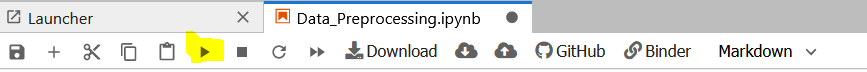

In [ ]:
#languange processing imports
import gensim, spacy, logging, warnings
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
import spacy
from openpyxl import Workbook

#For the text overview
from nltk import FreqDist

#Word Cloud and Visualization

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

## Tabelle mit Texten importieren <a class="anchor" id="2-bullet"></a>

Hier sehen Sie die importierte Excel-Tabelle

In [ ]:
df = pd.read_excel(('Data/uebungstexte_notebook.xlsx'), engine='openpyxl',) 
df.style.set_caption('Excel Tabelle').hide_index()

## Den Text "reinigen" und Stop-Wörter entfernen <a class="anchor" id="3-bullet"></a>

Nun wird der Text gereinigt, das heißt, es werden Satzzeichen entfernt, alle Wörter werden einheitlich klein geschrieben und Stop-Wörter werden entfernt. Stop-Wörter sind Wörter, die häufig vorkommen und haben für gewöhnlich keine Relevanz für weitere Analysen. Hierzu gehören Wörter wie "und", "auf", "mit" usw. 

In [ ]:
#Functions to clean, tokenize, and stem the data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text, language = 'german')
    return text

stop_words = stopwords.words('german')#change the language here

stop_words.extend([]) #add additional words here
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

def apply_all(text):
    return remove_stop_words(initial_clean(text))
df['tokenized'] = df['text'].apply(apply_all) 
df.style.set_caption('Text und Tokens').hide_index()

## Lemmatisierung von Wörtern <a class="anchor" id="4-bullet"></a>
Die lexikographische Reduktion der Flexionsformen eines Wortes auf eine Grundform, also die Festlegung der Grundform eines Lexems und die Anordnung der Lemmata wird auch Lemmatisierung genannt.

In [ ]:
from gensim.utils import simple_preprocess
def lemmatization(texts):
    texts_out = []
    nlp = spacy.load('de_core_news_sm')
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])   
    return texts_out

df['lemmatized'] = lemmatization(df['tokenized'])
df.style.set_caption('Text, tokens und lemmas').hide_index()

## Part of Speech Tagging <a class="anchor" id="5-bullet"></a>

Unter **Part-of-speech-Tagging** (POS-Tagging) versteht man die Zuordnung von Wörtern und Satzzeichen eines Textes zu Wortarten (englisch part of speech). Hierzu wird sowohl die Definition des Wortes als auch der Kontext (z. B. angrenzende Adjektive oder Nomen) berücksichtigt.

In [ ]:
def tagging(texts, allowed_postags=['NOUN']): # possible tags'NOUN', 'ADJ', 'ADV', 'VERB'
    texts_out = []
    nlp = spacy.load('de_core_news_sm')
    for sent in texts:
        doc = nlp(sent) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])   
    return texts_out

df['tagging'] = tagging(df['text'])
df.style.set_caption('Only nouns').hide_index()

## Named Entities Recognition <a class="anchor" id="6-bullet"></a>

In [ ]:
from spacy import displacy
for i in range(len(df)) : 
    df.iloc[i,6] = ' '.join(df.iloc[i,6])
NER = spacy.load('de_core_news_sm')
data_ready2 = NER(df['lemmatized'][0])
text = displacy.render(data_ready2,style="ent",jupyter=True)
print(text)

In [ ]:
nlp = spacy.load('de_core_news_sm')
list_ = df.groupby('lemmatized').apply(list)
doc = nlp(str(list_)) 
loc = [] 
for ent in doc.ents:
    if (ent.label_ == 'LOC'):
            loc.append(ent.text)
    freq = {}       
    for item in loc:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
loc = []
number = []
for key, value in freq.items():
    loc.append(key)
    number.append(value)
df_loc = pd.DataFrame(np.column_stack([loc]), 
                                columns=['Ort'])
df_number = pd.DataFrame(np.column_stack([number]), 
                                columns=['Anzahl']) 
df_ne = pd.concat([df_loc, df_number],axis=1)
df_ne.columns=['Ort', 'Anzahl']
df_ne.to_excel('locations.xlsx')
df_ne.style.set_caption('Named Entities_Locations').hide_index() 

## Gewünschten Text exportieren <a class="anchor" id="7-bullet"></a>

Am Ende können Sie die gewünschten Resultate in Form der Excel Tabelle exportieren. 

In [ ]:
deselectlist =[ 'tokenized', 'tagging']
selectlist =[x for x in df.columns if x not in deselectlist]
df = df[selectlist]
    
df.to_excel('results.xlsx')
df